# T/S Diagram from ECCO

In [19]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline

In [2]:
from xmovie import Movie

In [3]:
from xhistogram.xarray import histogram
import numpy as np
from matplotlib.colors import LogNorm

In [4]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

In [5]:
ds_ll = faces_dataset_to_latlon(ds)
ds_ll_drop = ds_ll.drop(['i', 'j', 'i_g', 'j_g', 'k', 'k_u', 'k_l', 'k_p1'])

In [6]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50)

#coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=100, i_g=100)
#ds = ds_ll_drop.reset_coords(drop=True).roll(i=100, i_g=100)
#ds

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
left_lon = 20
right_lon = 115
lower_lat = 38
upper_lat = 90

In [8]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

## **TRY TO PLOT EVERY TIMESTEP WITH XMOVIE**

### Juliu's XMovie package

In [ ]:
def custom_plotfunc(ds, fig, tt, salt=ds.SALT, temp=ds.THETA, Z=coords.Z):

    salt = salt.isel(time=tt, **lat_range, **lon_range)
    temp = temp.isel(time=tt, **lat_range, **lon_range)
    
    _, _, lev_broadcasted = xr.broadcast(salt, temp, coords.Z)
    
    ax = fig.subplots()
    
    scat = ax.scatter(salt, temp, c=abs(lev_broadcasted), marker='.', s=0.5)
    fig.colorbar(scat, label='Depth [m]', shrink=0.8, ticks=np.arange(0, 6000, 1000))
    
    ax.set_xlim(33.4, 35)
    ax.set_ylim(-2, 1.2)

    ax.set_xlabel('Salinity [psu]')
    ax.set_ylabel('Potential Temperature [˚C]')
    ax.set_title('T-S Diagram of Weddell Gyre \n 1992-2016 (ECCO)', fontsize=20)
    
    fig.subplots_adjust(top=0.8)
    
    return ax, scat

In [ ]:
#creating movie object
mov = Movie(ds.time, plotfunc=custom_plotfunc, 
            salt=ds.SALT, temp=ds.THETA, 
            Z=coords.Z, input_check=False, dpi=150)

In [ ]:
#frame preview
mov.preview(3)

In [ ]:
#create a movie!

#ds = ds.isel(time=slice(0, 10))

mov = Movie(ds.time, plotfunc=custom_plotfunc, 
            salt=ds.SALT, 
            temp=ds.THETA, 
            Z=coords.Z, input_check=False)
mov.save('movie_full_ECCO.mp4', progress=True)

# xhistogram T/S Diagram from ECCO

In [10]:
#salt_bins = np.linspace(31.5, 35.5, 100)
#theta_bins = np.linspace(-2, 4, 100)
salt_bins = np.linspace(31, 35, 100)
theta_bins = np.linspace(-2.5, 8, 100)
delta_salt = salt_bins[1] - salt_bins[0]
delta_theta = theta_bins[1] - theta_bins[0]

vol = (coords.hFacC * coords.rA * coords.drF).sel(**lat_range, **lon_range)

In [11]:
vol.sum().values

array(2.811443e+16, dtype=float32)

In [12]:
salt = ds.SALT.isel(**lat_range, **lon_range)
temp = ds.THETA.isel(**lat_range, **lon_range)

In [13]:
ts_hist = histogram(temp, salt, bins=[theta_bins, salt_bins],
                    weights=vol, dim=['i', 'j', 'k']).rename({'THETA_bin':'theta_bin',
                                                              'SALT_bin':'salt_bin'}) / (delta_salt * delta_theta)
ts_hist

<xarray.DataArray 'histogram_THETA_SALT' (time: 288, theta_bin: 99, salt_bin: 99)>
dask.array<truediv, shape=(288, 99, 99), dtype=float64, chunksize=(1, 99, 99), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [14]:
#taking hist mean over `time` takes average (notice the scales are diff in either plots)
ts_hist_mean = ts_hist.mean(dim='time')

# Load in `ts_hist_mean_ECCO.nc` ds and plot

In [16]:
ts_hist_mean = xr.open_dataarray('ts_hist_mean_ECCO.nc')

In [37]:
ts_hist_mean

<xarray.DataArray 'histogram_THETA_SALT' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

Text(0, 0.5, 'Potential Temperature [˚C]')

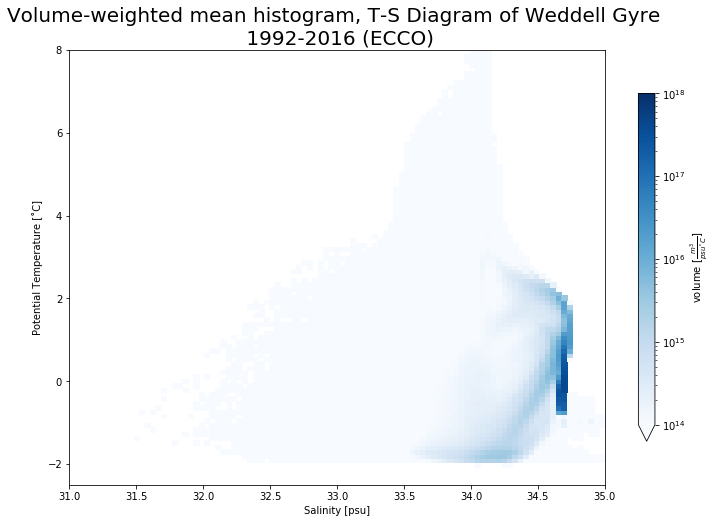

In [20]:
ts_hist_mean.where(ts_hist_mean>0).plot(norm=LogNorm(), figsize=(12,8), 
                                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'},
                                        cmap='Blues', vmin=1e14, vmax=1e18)

plt.title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 1992-2016 (ECCO)', fontsize=20)
plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')

## Movie!

In [44]:
def xhist_plot(ds, fig, tt, salt=ds.SALT, temp=ds.THETA):

    salt = salt.isel(time=tt, **lat_range, **lon_range)
    temp = temp.isel(time=tt, **lat_range, **lon_range)
    
    salt_bins = np.linspace(31, 35, 100)
    theta_bins = np.linspace(-2.5, 8, 100)
    
    delta_salt = salt_bins[1] - salt_bins[0]
    delta_theta = theta_bins[1] - theta_bins[0]
    
    vol = (coords.hFacC * coords.rA * coords.drF).isel(**lat_range, **lon_range)
    
    
    #Plotting
    
    ax = fig.subplots()
    
    ts_hist = histogram(temp, salt, bins=[theta_bins, salt_bins],
                        weights=vol, dim=['i', 'j', 'k']).rename({'THETA_bin':'theta_bin',
                                                                    'SALT_bin':'salt_bin'}) / (delta_salt * delta_theta)
        
    hist = ts_hist.where(ts_hist>0).plot(norm=LogNorm(), ax=ax, cmap='Blues', vmin=1e14, vmax=1e18,
                                         cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})
    
    timestamp = str(ds.time.isel(time=tt).values)
    ax.text(x=33,y=-4.2, s=timestamp[:10], 
            fontsize=18, weight='bold', horizontalalignment='center')

    ax.set_title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 1992-2016 (ECCO)', fontsize=20)
    ax.set_xlabel('Salinity [psu]')
    ax.set_ylabel('Potential Temperature [˚C]')
    
    fig.subplots_adjust(top=0.8)
    
    return ax, hist

In [45]:
#creating movie object
mov = Movie(ds.time, plotfunc=xhist_plot, 
            salt=ds.SALT, temp=ds.THETA, input_check=False, dpi=150)
#mov.save('movie.mp4')

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


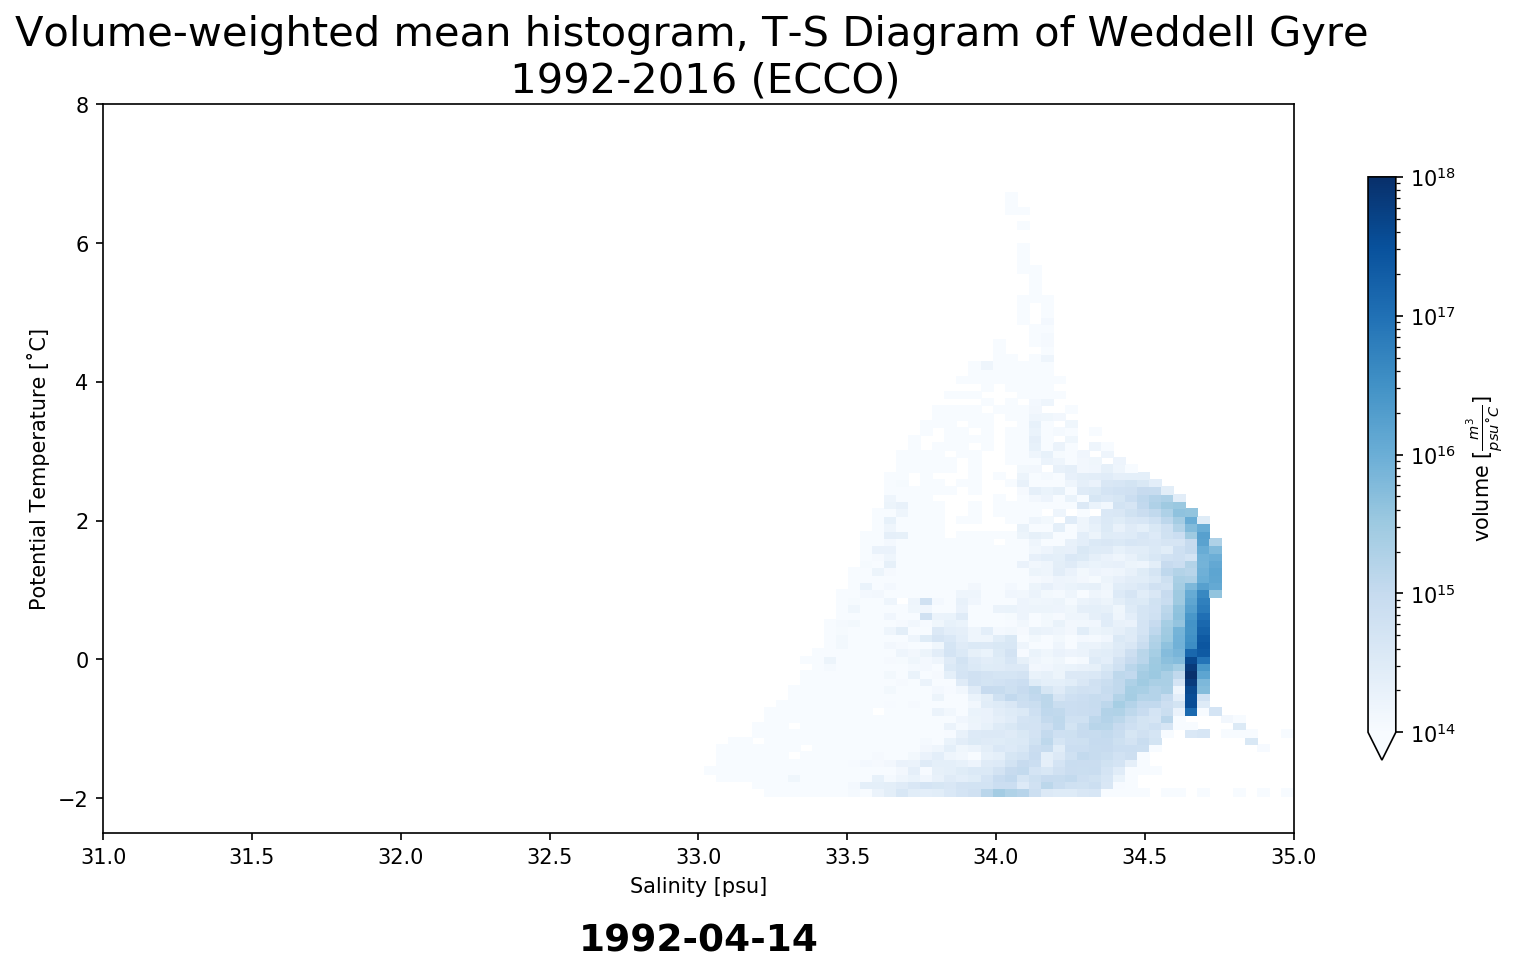

In [46]:
#frame preview
mov.preview(3)

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


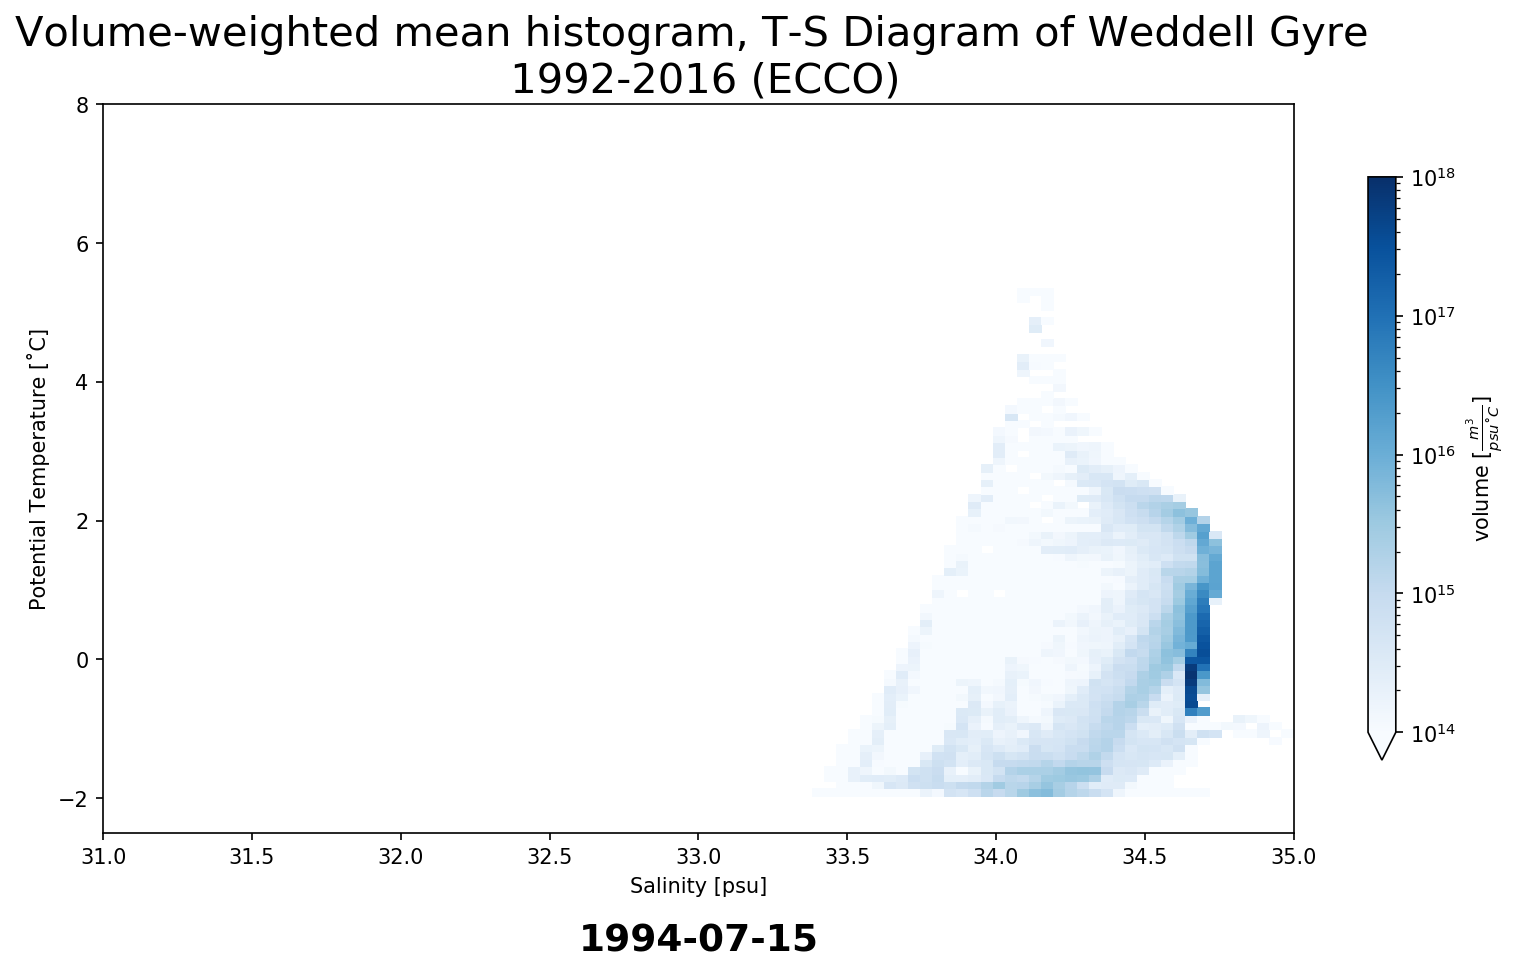

In [47]:
#frame preview
mov.preview(30)

In [52]:
#create a movie!

#dsr = ds.isel(time=slice(0,21))

mov = Movie(ds.time, plotfunc=xhist_plot, 
            salt=ds.SALT, 
            temp=ds.THETA, 
            input_check=False, dpi=150)

mov.save('movie_xhist_ECCO_Blues.mp4', progress=True)

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/srv/conda/envs/notebook/lib/python3.7/site-packages


Movie created at movie_xhist_ECCO_Blues.mp4
